In [33]:
import pandas as pd
import numpy as np
import torch
import botorch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import qExpectedImprovement, qNoisyExpectedImprovement
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from rdkit import Chem
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Loading dataset
df = pd.read_csv("/Users/amitchaudhary/Downloads/archive-4/AChE_Bioactivity_data_1.csv")

In [34]:
def clean_chembl_dataset(df):
    original_size = len(df)
    df_clean = df.copy()
    
    # Removeing completely empty columns
    empty_cols = df_clean.columns[df_clean.isna().all()].tolist()
    if empty_cols:
        print(f"\n1. Removing empty columns: {empty_cols}")
        df_clean = df_clean.drop(columns=empty_cols)
    
    #  Filtering for IC50 data only
    print(f"\n2. Filtering for IC50 measurements...")
    ic50_before = len(df_clean)
    df_clean = df_clean[df_clean['standard_type'] == 'IC50']
    print(f"   Kept {len(df_clean)}/{ic50_before} IC50 measurements")
    
    #Removing rows with missing critical data
    print(f"\n3. Removing rows with missing critical data...")
    before_critical = len(df_clean)
    
    # Removing missing standard values
    df_clean = df_clean[df_clean['standard_value'].notna()]
    print(f"   - After removing missing standard_value: {len(df_clean)}")
    
    # Removing missing SMILES
    df_clean = df_clean[df_clean['canonical_smiles'].notna()]
    print(f"   - After removing missing SMILES: {len(df_clean)}")
    

    
    # Keeping  valid data 
    if 'data_validity_comment' in df_clean.columns:
        valid_before = len(df_clean)
        df_clean = df_clean[df_clean['data_validity_comment'].isna()]
        print(f"   - After validity filter: {len(df_clean)}/{valid_before}")
    
    # Keeping only exact measurements (= relation)
    if 'standard_relation' in df_clean.columns:
        relation_before = len(df_clean)
        df_clean = df_clean[df_clean['standard_relation'] == '=']
        print(f"   - After exact measurements filter: {len(df_clean)}/{relation_before}")
    
    #Unit consistency and value validation
    print(f"\n5. Validating units and values...")
    
    # Checking units distribution
    if 'standard_units' in df_clean.columns:
        unit_counts = df_clean['standard_units'].value_counts()
        print(f"   Unit distribution: {unit_counts.to_dict()}")
        
        # Keeping only nM measurements (most common for IC50)
        unit_before = len(df_clean)
        df_clean = df_clean[df_clean['standard_units'] == 'nM']
        print(f"   - After nM unit filter: {len(df_clean)}/{unit_before}")
    
    # Removing the non-positive values
    value_before = len(df_clean)
    df_clean = df_clean[df_clean['standard_value'] > 0]
    print(f"   - After positive value filter: {len(df_clean)}/{value_before}")
    
    #Handleing duplicate compounds
    print(f"\n6. Handling duplicate compounds...")
    duplicate_count = df_clean['canonical_smiles'].duplicated().sum()
    print(f"   Found {duplicate_count} duplicate SMILES")
    
    if duplicate_count > 0:
        # Group by SMILES and take median potency
        aggregation_rules = {
            'standard_value': 'median',
            'molecule_chembl_id': 'first',
            'assay_chembl_id': 'count',
            'document_chembl_id': 'nunique'
        }
        
        # Adding pchembl_value if available
        if 'pchembl_value' in df_clean.columns:
            aggregation_rules['pchembl_value'] = 'median'
        
        df_clean = df_clean.groupby('canonical_smiles').agg(aggregation_rules).reset_index()
        df_clean = df_clean.rename(columns={
            'assay_chembl_id': 'num_assays', 
            'document_chembl_id': 'num_publications'
        })
    
    print(f"   After deduplication: {len(df_clean)} unique compounds")
    
    #Calculating potency metrics
    print(f"\n7. Calculating potency metrics...")
    
    # Converting to pIC50 (-log10(IC50 in M))
    df_clean['pIC50'] = -np.log10(df_clean['standard_value'] * 1e-9)
    df_clean['IC50_nM'] = df_clean['standard_value']
    
    print(f"   pIC50 range: {df_clean['pIC50'].min():.2f} - {df_clean['pIC50'].max():.2f}")
    print(f"   IC50 range: {df_clean['IC50_nM'].min():.2f} - {df_clean['IC50_nM'].max():.2f} nM")
    
    #Generate molecular descriptors
    print(f"\n8. Generating molecular descriptors...")
    df_clean = generate_molecular_descriptors(df_clean)
    
    print(f"\n" + "="*60)
    print("CLEANING COMPLETE")
    print("="*60)
    print(f"Original dataset: {original_size} rows")
    print(f"Cleaned dataset: {len(df_clean)} rows")
    print(f"Data retention: {len(df_clean)/original_size*100:.1f}%")
    
    return df_clean

In [46]:
def generate_molecular_descriptors(df):
    """
    Generate molecular descriptors and fingerprints for optimization
    """
    def safe_mol_from_smiles(smiles):
        """Safely convert SMILES to RDKit molecule"""
        if pd.isna(smiles):
            return None
        try:
            mol = Chem.MolFromSmiles(str(smiles))
            if mol is None:
                return None
            Chem.SanitizeMol(mol)
            return mol
        except:
            return None
    
    print("   Converting SMILES to molecules...")
    # Converting SMILES to molecules
    df['molecule'] = df['canonical_smiles'].apply(safe_mol_from_smiles)
    
    successful_conversions = df['molecule'].notna().sum()
    
    if successful_conversions == 0:
        print("   WARNING: No molecules could be converted from SMILES!")
        print("   This could be due to:")
        print("   - Invalid SMILES format")
        print("   - RDKit installation issues")
        print("   - Special characters in SMILES")
        return df
    
    # Removing failed conversions
    initial_count = len(df)
    df = df[df['molecule'].notna()]
    print(f"   Removed {initial_count - len(df)} failed conversions")
    
    # Calculating basic descriptors (using only standard Descriptors module)
    def calculate_descriptors(mol):
        if mol is None:
            return {}
        try:
            desc_dict = {
                'mol_weight': Descriptors.MolWt(mol),
                'logp': Descriptors.MolLogP(mol),
                'hbd': Descriptors.NumHDonors(mol),
                'hba': Descriptors.NumHAcceptors(mol),
                'rotatable_bonds': Descriptors.NumRotatableBonds(mol),
                'heavy_atoms': Descriptors.HeavyAtomCount(mol),
                'rings': Descriptors.RingCount(mol),
                'tpsa': Descriptors.TPSA(mol),
                'aromatic_rings': Descriptors.NumAromaticRings(mol),
                'amide_bonds': Descriptors.NumAmideBonds(mol),
            }
            
            # Trying to calculate additional descriptors with error handling
            try:
                desc_dict['num_heteroatoms'] = Descriptors.NumHeteroatoms(mol)
            except:
                desc_dict['num_heteroatoms'] = 0
                
            try:
                desc_dict['num_aromatic_heterocycles'] = Descriptors.NumAromaticHeterocycles(mol)
            except:
                desc_dict['num_aromatic_heterocycles'] = 0
                
            try:
                desc_dict['num_aliphatic_heterocycles'] = Descriptors.NumAliphaticHeterocycles(mol)
            except:
                desc_dict['num_aliphatic_heterocycles'] = 0
                
            return desc_dict
            
        except Exception as e:
            print(f"      Error calculating descriptors: {e}")
            return {}
    
    print("   Calculating molecular descriptors...")
    # Applying descriptor calculation
    descriptors_list = []
    successful_calcs = 0
    
    for idx, mol in enumerate(df['molecule']):
        if idx % 500 == 0:  # Progress indicator
            print(f"      Processed {idx}/{len(df)} molecules...")
        desc = calculate_descriptors(mol)
        if desc:  # Only count if we got some descriptors
            successful_calcs += 1
        descriptors_list.append(desc)
    
    descriptors_df = pd.DataFrame(descriptors_list)
    
    # Checking if we got any descriptors
    if descriptors_df.empty:
        print("   WARNING: No descriptors could be calculated!")
        return df
    
    print(f"   Successful descriptor calculations: {successful_calcs}/{len(df)}")
    
    # Combining with main dataframe
    df = pd.concat([df, descriptors_df], axis=1)
    
    # Calculating synthetic accessibility score (simplified)
    def calculate_sa_score(mol):
        """Simplified synthetic accessibility metric"""
        if mol is None:
            return 10.0
        try:
            mw = Descriptors.MolWt(mol)
            rings = Descriptors.RingCount(mol)
            
            # Counting chiral centers 
            try:
                chiral_centers = len(Chem.FindMolChiralCenters(mol, includeUnassigned=True))
            except:
                chiral_centers = 0
                
            # Counting complex rings safely
            try:
                ring_info = mol.GetRingInfo()
                complex_rings = sum(1 for ring in ring_info.AtomRings() if len(ring) > 6)
            except:
                complex_rings = 0
            
            # Heuristic score (1=easy, 10=hard)
            sa_score = (mw/500 * 2 + rings * 0.5 + chiral_centers * 1.5 + complex_rings * 2)
            return min(10, max(1, sa_score))
        except:
            return 10.0
    
    print("   Calculating synthetic accessibility scores...")
    df['sa_score'] = df['molecule'].apply(calculate_sa_score)
    
    print(f"   Generated {len(descriptors_df.columns)} molecular descriptors")
    print(f"   Available descriptors: {list(descriptors_df.columns)}")
    print(f"   SA score range: {df['sa_score'].min():.1f} - {df['sa_score'].max():.1f}")
    
    # Droping the molecule column to save space
    df = df.drop(columns=['molecule'])
    
    return df

def visualize_cleaned_data(df):

    print("GENERATING DATA VISUALIZATIONS")
    
    # Checking which descriptor columns are available
    descriptor_cols = ['mol_weight', 'logp', 'hbd', 'hba', 'rotatable_bonds', 'tpsa', 'sa_score', 'rings']
    available_cols = [col for col in descriptor_cols if col in df.columns]
    
    print(f"Available descriptor columns: {available_cols}")
    
    if not available_cols:
        print("No molecular descriptors available for visualization")
        plt.figure(figsize=(10, 6))
        plt.hist(df['pIC50'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
        plt.xlabel('pIC50')
        plt.ylabel('Frequency')
        plt.title('Distribution of pIC50 Values')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('pIC50_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()
        return
    
    # Createing subplots based on available columns
    n_plots = min(len(available_cols) + 1, 6)  # +1 for pIC50, max 6 plots
    n_rows = (n_plots + 2) // 3  # Calculate rows needed
    fig, axes = plt.subplots(n_rows, 3, figsize=(18, 5 * n_rows))
    
    # Flatten thr axes for easy indexing
    if n_rows > 1:
        axes = axes.flatten()
    else:
        axes = [axes] if n_plots == 1 else axes
    
    #pIC50 distribution (always available)
    axes[0].hist(df['pIC50'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    axes[0].set_xlabel('pIC50')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution of pIC50 Values')
    axes[0].grid(True, alpha=0.3)
    
    # Ploting the available descriptors
    colors = ['orange', 'green', 'red', 'purple', 'brown', 'pink']
    for i, col in enumerate(available_cols[:5]):  # Plot up to 5 descriptors
        ax_idx = i + 1
        if ax_idx < len(axes):
            axes[ax_idx].hist(df[col], bins=30, edgecolor='black', alpha=0.7, color=colors[i % len(colors)])
            axes[ax_idx].set_xlabel(col.replace('_', ' ').title())
            axes[ax_idx].set_ylabel('Frequency')
            axes[ax_idx].set_title(f'Distribution of {col.replace("_", " ").title()}')
            axes[ax_idx].grid(True, alpha=0.3)
    
    # Hiding empty subplots
    for i in range(len(available_cols) + 1, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('cleaned_data_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Correlation heatmap 
    if len(available_cols) >= 2:
        correlation_cols = ['pIC50'] + available_cols
        corr_matrix = df[correlation_cols].corr()
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True, fmt='.2f')
        plt.title('Molecular Descriptor Correlations')
        plt.tight_layout()
        plt.savefig('descriptor_correlations.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    #Synthetic Accessibility vs Potency
    if 'sa_score' in df.columns:
        plt.figure(figsize=(10, 6))
        plt.scatter(df['sa_score'], df['pIC50'], alpha=0.6, color='green')
        plt.xlabel('Synthetic Accessibility Score (lower = easier)')
        plt.ylabel('pIC50')
        plt.title('Potency vs Synthetic Accessibility')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('potency_vs_sa.png', dpi=300, bbox_inches='tight')
        plt.show()


In [47]:
cleaned_df = clean_chembl_dataset(df)


# Saving cleaned dataset
output_file = "cleaned_ACHE_data_optimization_ready.csv"

# Selecting only the columns that exist for saving
available_columns = cleaned_df.columns.tolist()

# Saving the dataset
cleaned_df.to_csv(output_file, index=False)



1. Removing empty columns: ['assay_variant_accession', 'assay_variant_mutation', 'standard_text_value', 'standard_upper_value', 'text_value', 'toid']

2. Filtering for IC50 measurements...
   Kept 8205/15542 IC50 measurements

3. Removing rows with missing critical data...
   - After removing missing standard_value: 6949
   - After removing missing SMILES: 6947
   - After validity filter: 6352/6947
   - After exact measurements filter: 5801/6352

5. Validating units and values...
   Unit distribution: {'nM': 5787, 'ug.mL-1': 14}
   - After nM unit filter: 5787/5801
   - After positive value filter: 5787/5787

6. Handling duplicate compounds...
   Found 1163 duplicate SMILES
   After deduplication: 4624 unique compounds

7. Calculating potency metrics...
   pIC50 range: 4.00 - 10.96
   IC50 range: 0.01 - 100000.00 nM

8. Generating molecular descriptors...
   Converting SMILES to molecules...
   Removed 0 failed conversions
   Calculating molecular descriptors...
      Processed 0/4624

GENERATING DATA VISUALIZATIONS
Available descriptor columns: ['mol_weight', 'logp', 'hbd', 'hba', 'rotatable_bonds', 'tpsa', 'sa_score', 'rings']


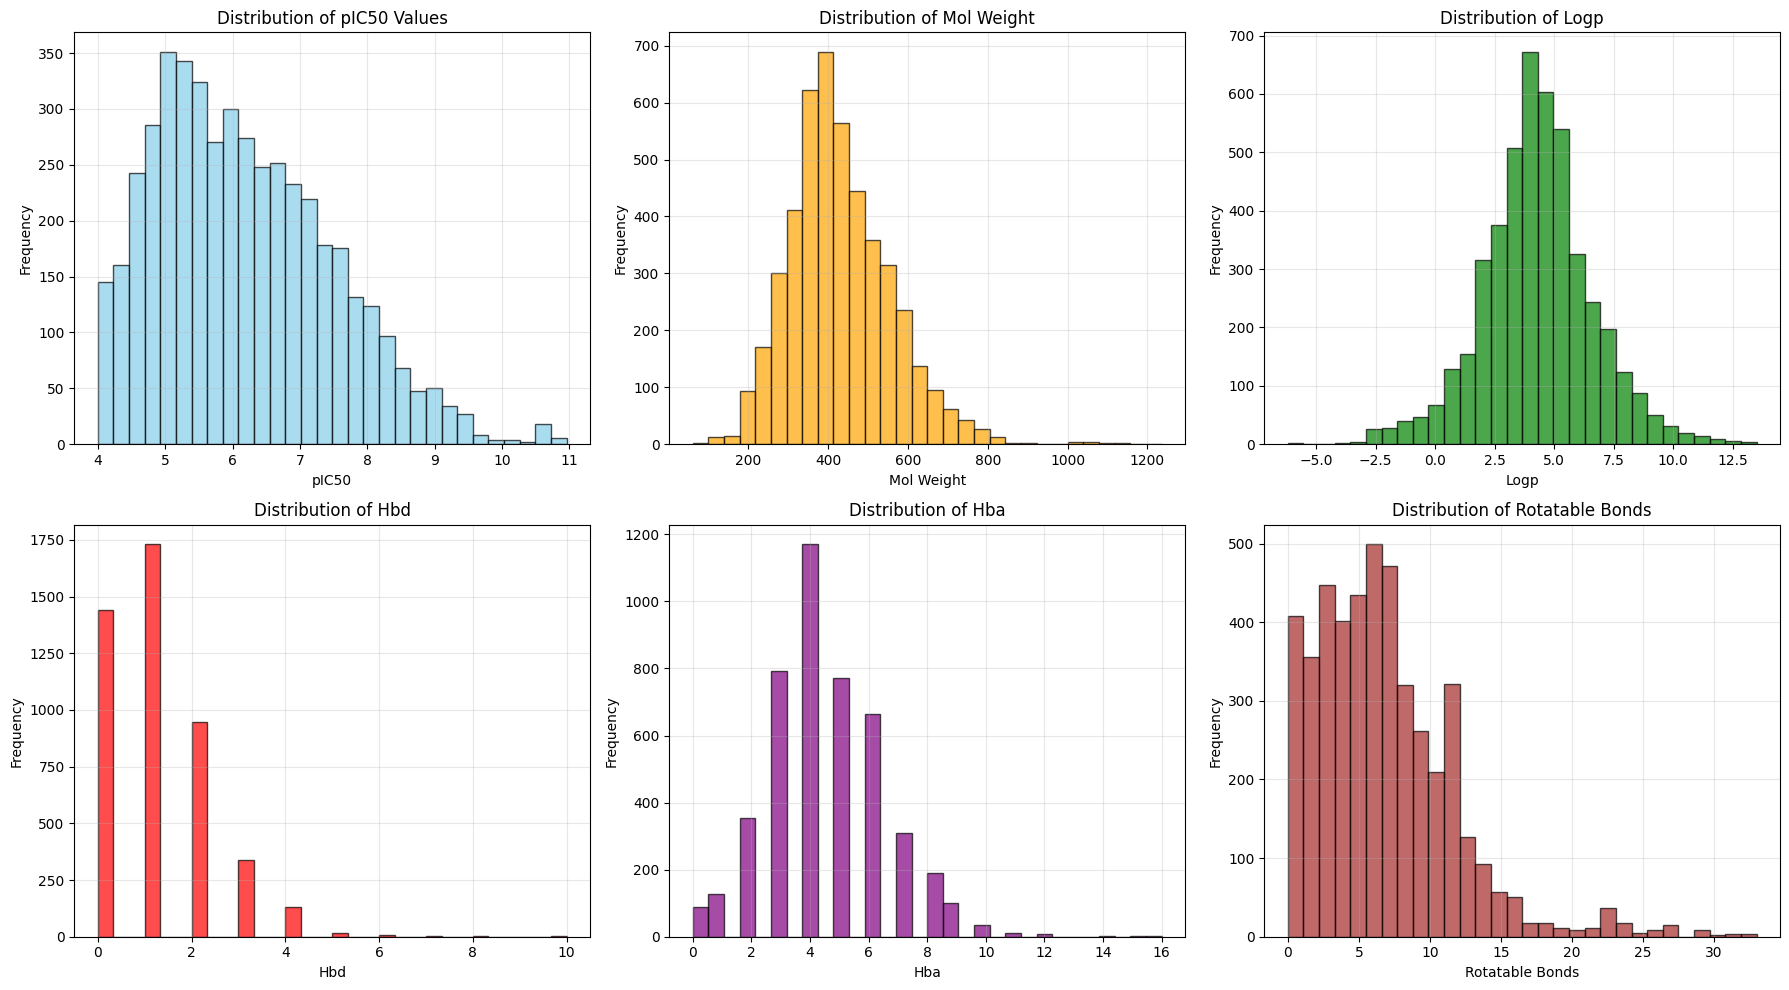

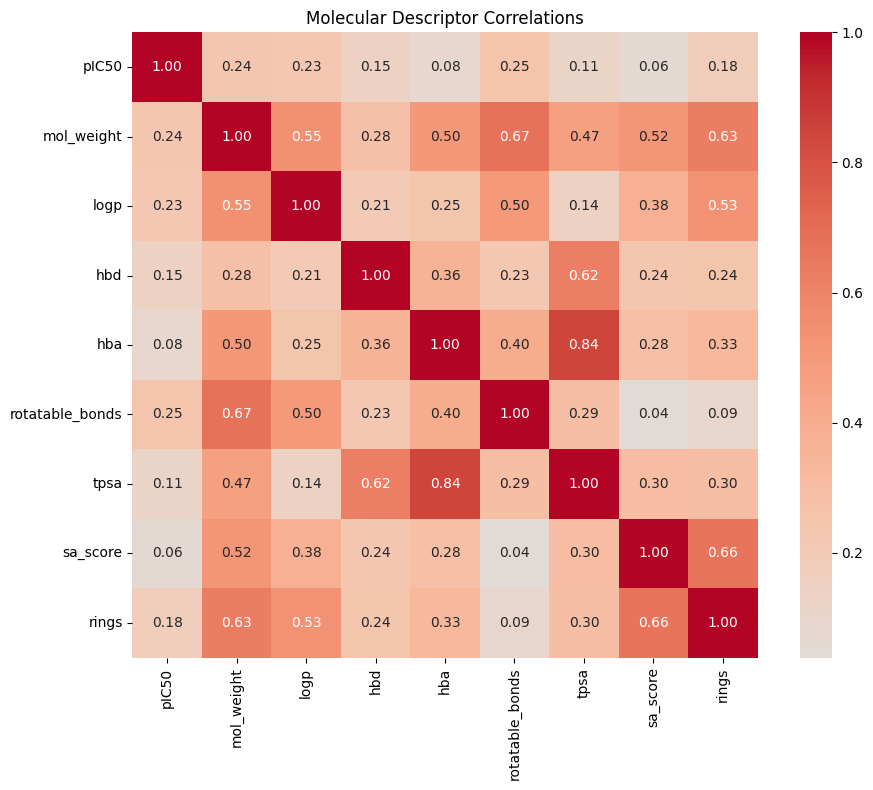

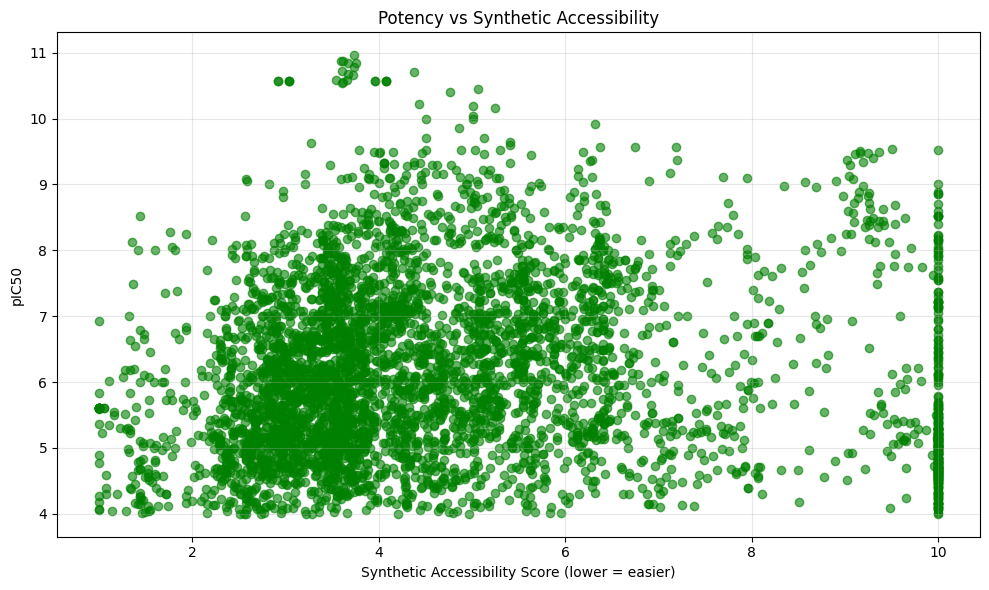

In [49]:
# Generating visualizations 
try:
    visualize_cleaned_data(cleaned_df)
except Exception as e:
    print(f"Visualization error: {e}")
    print("Continuing with data saving")


In [50]:
print("FINAL CLEANED DATASET SUMMARY")
print(f"Saved to: {output_file}")
print(f"Final dataset shape: {cleaned_df.shape}")
print(f"Key columns available:")
print(f"  - SMILES: {cleaned_df['canonical_smiles'].notna().sum()}")
print(f"  - pIC50 values: {cleaned_df['pIC50'].notna().sum()}")
print(f"  - IC50 values: {cleaned_df['IC50_nM'].notna().sum()}")


# Checking which molecular descriptors were successfully created
descriptor_cols = ['mol_weight', 'logp', 'hbd', 'hba', 'rotatable_bonds', 'tpsa', 'sa_score', 'rings']
available_descriptors = [col for col in descriptor_cols if col in cleaned_df.columns]
print(f"  - Molecular descriptors: {len(available_descriptors)}")

FINAL CLEANED DATASET SUMMARY
Saved to: cleaned_ACHE_data_optimization_ready.csv
Final dataset shape: (4624, 22)
Key columns available:
  - SMILES: 4624
  - pIC50 values: 4624
  - IC50 values: 4624
  - Molecular descriptors: 8
